<h2 style='color:orange'> Import Basic Libraries </h2>

In [4]:
import torch  
import os
import numpy as np
import wandb
import platform
import sys
from tqdm import tqdm
from datetime import datetime
import random
from datasets import load_dataset
from transformers import Trainer, TrainingArguments, PreTrainedModel
from torchvision import transforms
from torch.utils.data import Dataset
import wandb
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, fbeta_score
from transformers import EarlyStoppingCallback
from transformers import PretrainedConfig
from typing import List
from typing import Type
import torch.nn as nn
from collections import Counter
import albumentations as A
from functools import partial
from torchvision.transforms import v2




/Users/pawelpiwowarski/miniforge3/envs/tf/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/pawelpiwowarski/miniforge3/envs/tf/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <3EF8D74C-9F11-3C9E-85DB-9E76BCCBE7A0> /Users/pawelpiwowarski/miniforge3/envs/tf/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <03BFC270-EF54-36FC-B102-371F5164D3C9> /Users/pawelpiwowarski/miniforge3/envs/tf/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/pawelpiwowarski/miniforge3/envs/tf/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning

<h2> Manage Configuration </h2>

In [5]:
image_size = 224
batch_size = 128
num_classes = 3
channels = 3
seed = 1234
random_generator = np.random.default_rng(seed)
folder_for_best_architectures = './best_architectures/'
dataset_path = "pawlo2013/chest_xray"

has_gpu = torch.cuda.is_available()
has_mps = getattr(torch, 'has_mps', False)
device = "mps" if getattr(torch, 'has_mps', False) \
    else "cuda" if torch.cuda.is_available() else "cpu"
device = "mps" if getattr(
    torch, 'has_mps', False) else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Python Platform: {platform.platform()}")
print(f"PyTorch Version: {torch.__version__}")
print(f"Python {sys.version}")


print("GPU is", "available" if has_gpu else "NOT AVAILABLE")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")

def calculate_class_weights(dataset_path, device):
    # Load the dataset
    dataset = load_dataset(dataset_path)
    
    # Assuming the label column is named 'label'
    train_labels = dataset['train']['label']
    
    # Count the number of samples in each class
    label_counts = Counter(train_labels)
    
    # Get total number of samples
    total_samples = len(train_labels)
    
    # Calculate class weights: inverse of class frequency
    class_weights = {label: total_samples / count for label, count in label_counts.items()}
    
    # Convert class weights to tensor and move to the specified device
    class_weights_tensor = torch.tensor(
        [class_weights[label] for label in range(len(class_weights))],
        dtype=torch.float
    ).to(device)
    
    return class_weights_tensor

# Example usage


class_weights = calculate_class_weights(dataset_path, device)
print(class_weights)


dataset = load_dataset(dataset_path)
train_dataset = dataset['train']
class_names = train_dataset.features['label'].names
print(class_names)


/var/folders/cm/2c5qsgtd2z9_c__1cmj825dm0000gn/T/ipykernel_25075/3840758500.py:11: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  has_mps = getattr(torch, 'has_mps', False)
/var/folders/cm/2c5qsgtd2z9_c__1cmj825dm0000gn/T/ipykernel_25075/3840758500.py:12: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = "mps" if getattr(torch, 'has_mps', False) \
/var/folders/cm/2c5qsgtd2z9_c__1cmj825dm0000gn/T/ipykernel_25075/3840758500.py:14: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = "mps" if getattr(


Python Platform: macOS-14.4.1-arm64-arm-64bit
PyTorch Version: 2.3.0
Python 3.10.9 | packaged by conda-forge | (main, Feb  2 2023, 20:26:08) [Clang 14.0.6 ]
GPU is NOT AVAILABLE
MPS (Apple Metal) is AVAILABLE
tensor([2.0147, 4.1631, 3.7958], device='mps:0')
['Bacterial', 'Normal', 'Viral']


In [3]:
class CustomDataset(Dataset):
    def __init__(self, dataset, device, transform=None, shuffle=False):
        self.dataset = dataset
        self.transform = transform
        self.device = device
        
        if shuffle:
            self.dataset = self.dataset.shuffle(seed)
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["image"]
        label = item["label"]
        if self.transform:
            image = self.transform(image)
        return {"input_ids": image, "labels": label}

In [12]:
train_transforms = v2.Compose([

    v2.RandomRotation(degrees=(-10, 10)),  # Very slight rotation
    v2.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    v2.Resize(size=(image_size, image_size)),
    v2.ToTensor(),
    v2.Lambda(lambda t: (t * 2) - 1),  # Normalize to range [-1, 1]
])

initial_transforms = transforms.Compose(
                [
                    v2.Resize((image_size, image_size)),
                    v2.ToTensor(),
                    v2.Lambda(lambda t: (t * 2) - 1),
  
                ]
            )
    

def perform_training_transforms(image):

    augmented_image = train_transforms(image.convert("RGB"))


    return augmented_image

def perform_initial_val_test_transforms(image):
    return initial_transforms(image.convert("RGB"))



def perform_augmentation_for_showing(examples):
        examples['image']   = [train_transforms(image.convert("RGB")) for image in examples["image"]]

        return examples




<h2> Show example of the Data Available </h2>

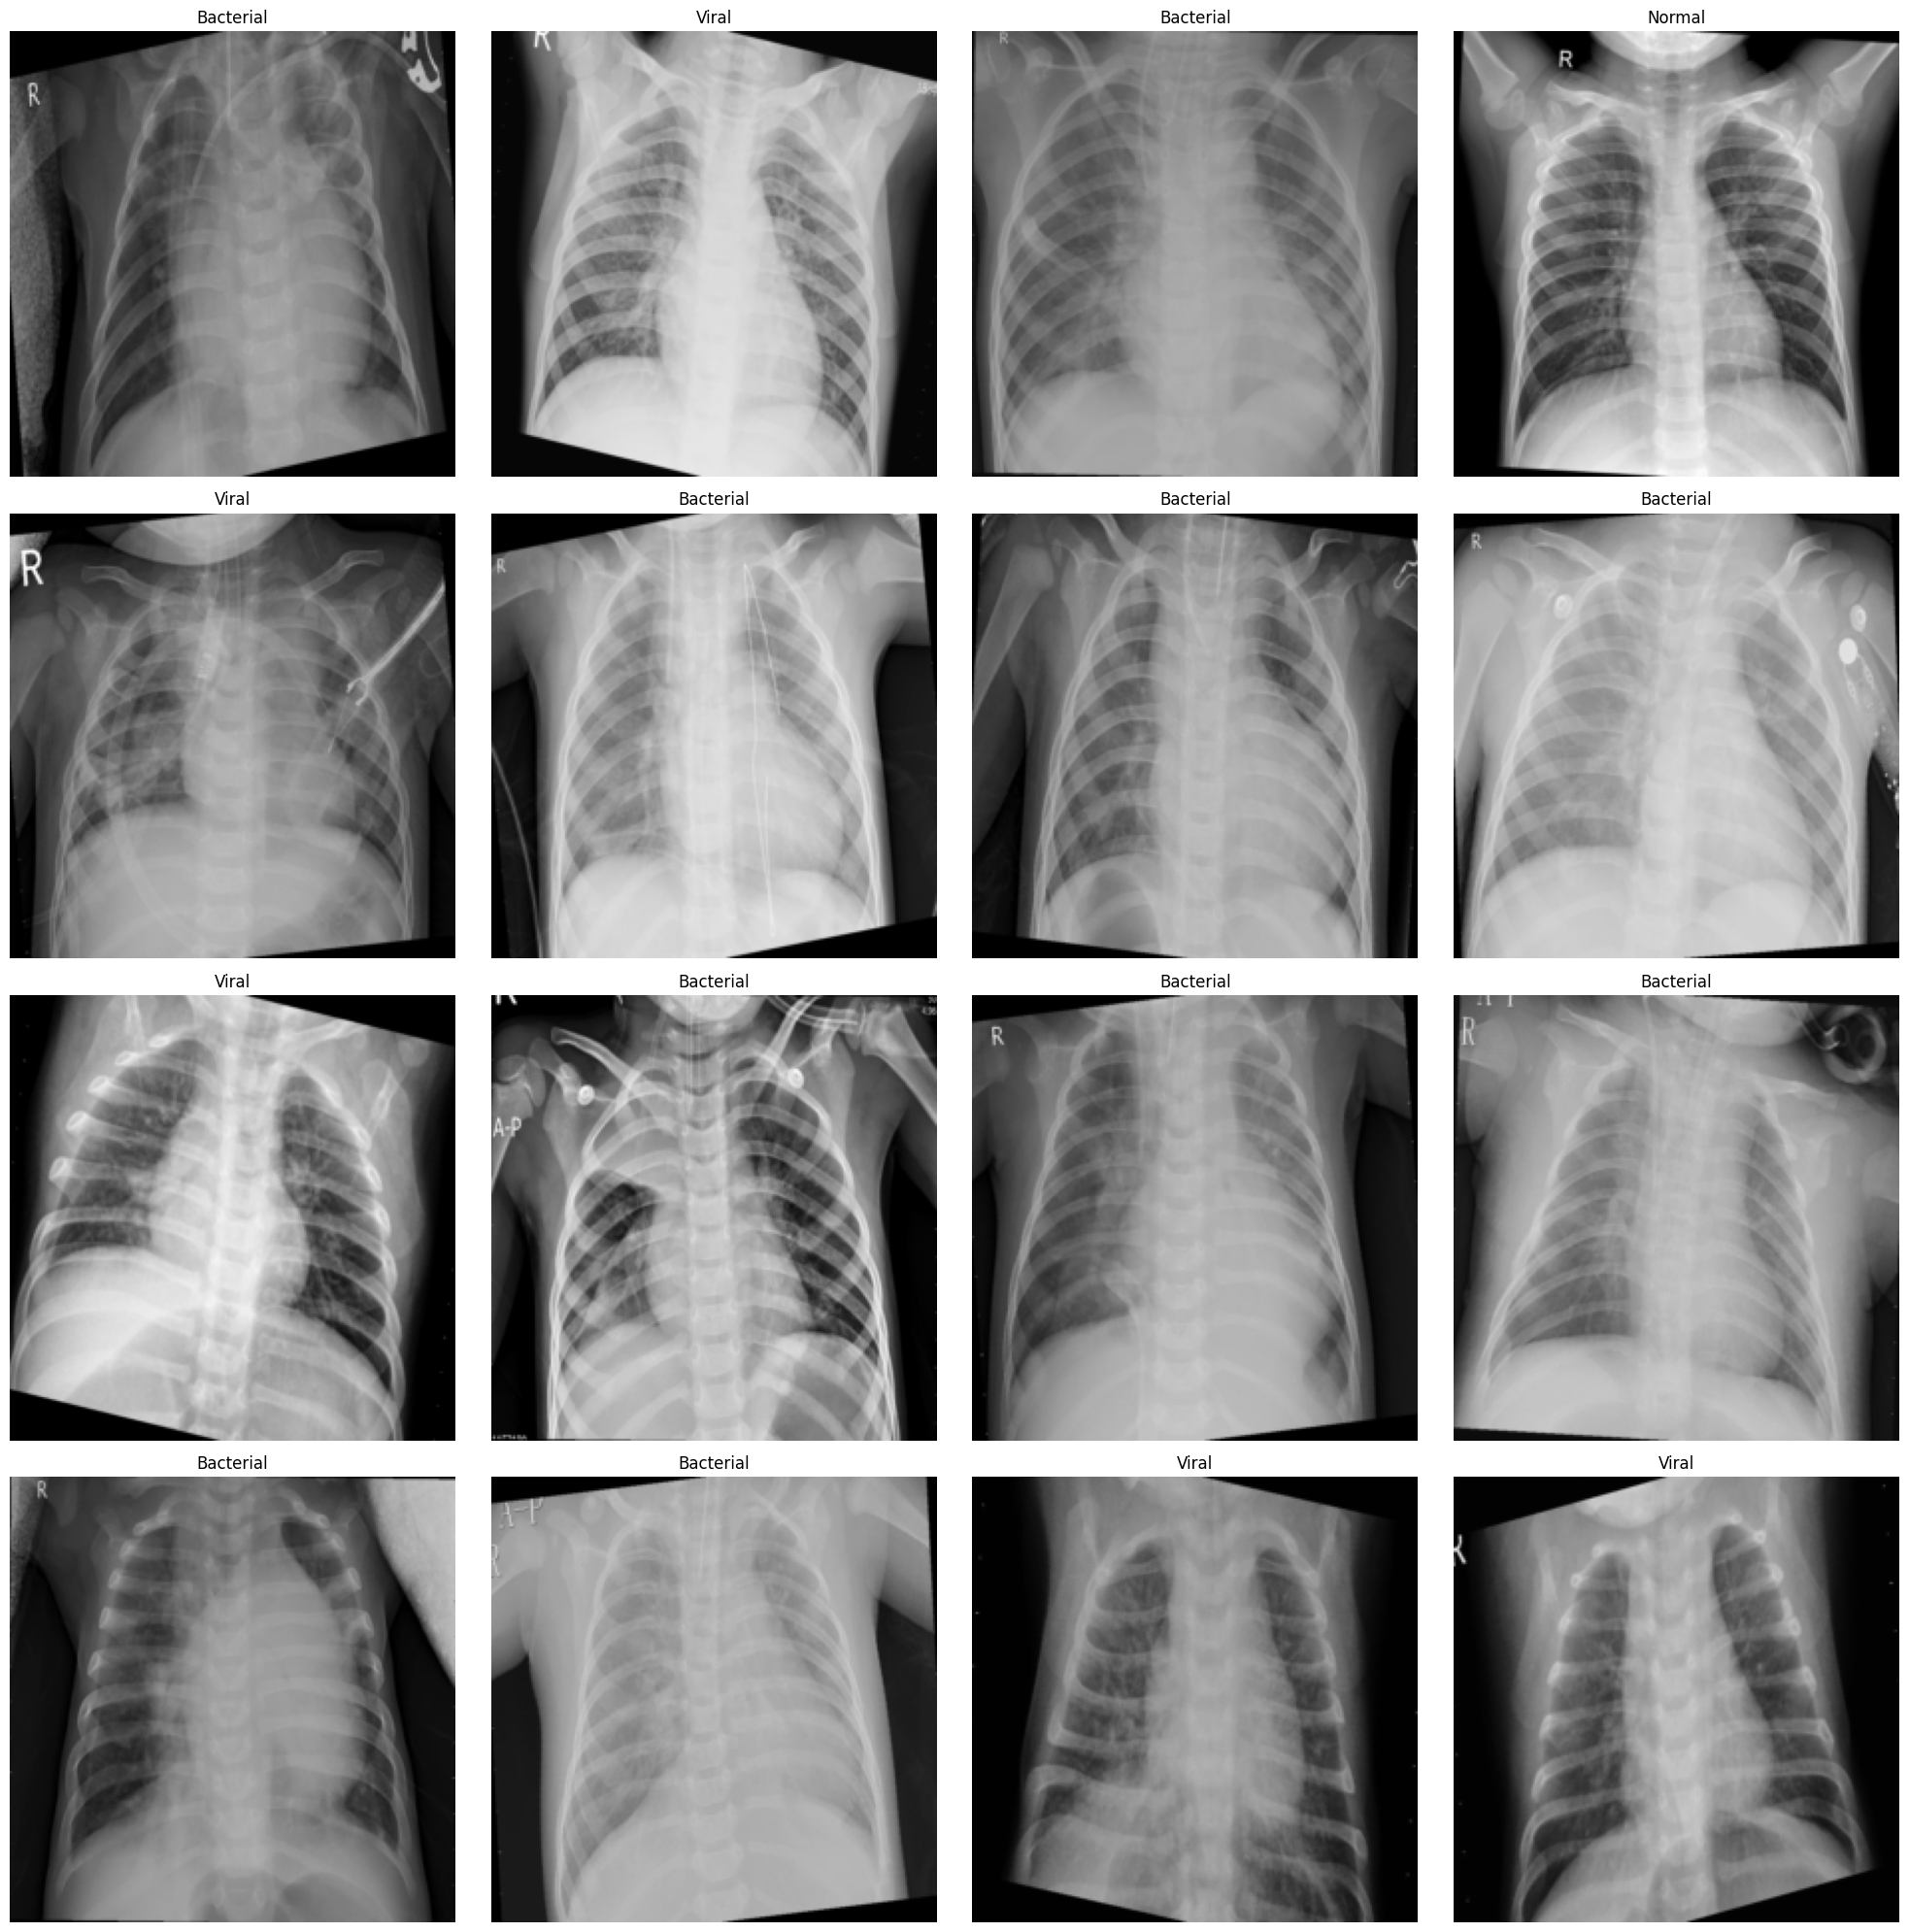

In [13]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Assuming `class_names` is a list of class names corresponding to labels

def reverse_normalize(tensor):
    return (tensor + 1) / 2  # Reversing the normalization step that mapped to [-1, 1]

def show_batch(batch):
    images, labels = batch['image'], batch['label']
    batch_size = images.size(0)
    grid_size = int(np.ceil(np.sqrt(batch_size)))
    
    fig, ax = plt.subplots(grid_size, grid_size, figsize=(20, 20))
    ax = ax.flatten()
    
    for i in range(grid_size * grid_size):
        if i < batch_size:
            image = reverse_normalize(images[i]).permute(1, 2, 0).numpy()  # Convert to HWC format
            ax[i].imshow(image)
            ax[i].set_title(class_names[labels[i]])
        ax[i].axis('off')
    
    plt.tight_layout()
    plt.show()


train_dataset = dataset['train'].with_transform(perform_augmentation_for_showing)
# Create the DataLoader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)

# Get a batch of images
see_batch = next(iter(train_loader))

# Show the batch
show_batch(see_batch)


In [14]:

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    # Overall accuracy
    acc = accuracy_score(labels, preds)
    # Precision, recall, and F1 score
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted", zero_division=0)     
    # Confusion matrix to calculate per-class accuracy
    cm = confusion_matrix(labels, preds)
    per_class_acc = cm.diagonal() / cm.sum(axis=1)
    # Prepare the per-class accuracy in a dictionary
    per_class_accuracy = {f"accuracy_class_{class_names[i]}": acc for i, acc in enumerate(per_class_acc)}
    # Combine all metrics into one dictionary
    metrics = {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }
    metrics.update(per_class_accuracy)
    # log the confusion matrix to W&B
    wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(probs=None,
                                                                y_true=labels,
                                                                preds=preds,
                                                                class_names=class_names)})   
    return metrics
   
class CustomConvNextConfig(PretrainedConfig):
    model_type = "custom_convnext"
    def __init__(self,
                 input_channels: int = 3,
                 num_classes: int = 3,
                 device: str = 'cpu',
                 convnext_mult: int = 2,
                 layer_norm: bool = False,  # Fixed Bool to bool
                 dropout: float = 0.0,
                 pooling_choice: str = "MaxPool2d",
                 activation_choice: str = "ReLU",
                 use_residual: bool = False,
                 **kwargs  # Add a comma before **kwargs
                 ):

        # Initialize class attributes
        self.input_channels = input_channels
        self.num_classes = num_classes
        self.device = device
        self.convnext_mult = convnext_mult
        self.layer_norm = layer_norm
        self.dropout = dropout
        self.pooling_choice = pooling_choice
        self.activation_choice = activation_choice
        self.use_residual = use_residual

        # Call the super class's constructor
        super().__init__(**kwargs)

<h2 style='color:green'> Best Baseline CNN </h2> 

In [15]:
def calculate_halving_steps(input_size):
    # Ensure the input size is greater than 0
    if input_size <= 0:
        raise ValueError("The input size must be a positive integer")
    # Initialize the halving step counter
    halving_steps = 0
    # Keep halving the size until it reaches 1
    while input_size > 1:
        input_size = input_size // 2
        halving_steps += 1
    return halving_steps




class PretrainedWraper(PreTrainedModel):

    config_class = CustomConvNextConfig


    def __init__(self, config, class_weights: torch.Tensor = torch.tensor([1.0,1.0,1.0])):

        super().__init__(config)

        self.class_weights = class_weights.to(config.device)

        self.model = CNN(
            input_size=config.image_size,
            device=config.device,
            num_classes=config.num_classes,
            pooling_choice=config.pooling_choice,
            activation_choice=config.activation_choice,
            convnext_mult=config.convnext_mult,
            layer_norm=config.layer_norm,
            dropout=config.dropout,
            use_residual=config.use_residual,
        ).to(config.device)

    
    def forward(self, input_ids, labels=None):
        logits = self.model(input_ids)
        if labels is not None:
            loss = torch.nn.NLLLoss(weight=self.class_weights)(logits, labels)
            return {"loss": loss, "logits": logits}
        return {"logits": logits}



class CNN(nn.Module):
    def __init__(self, input_size, device, num_classes, channels=3, pooling_choice=None, activation_choice=None, convnext_mult=None, layer_norm = None, dropout=None, use_residual=None ):
        super(CNN, self).__init__()
        # check how many halving steps we can do
        self.halving_steps = calculate_halving_steps(input_size)
        self.num_classes = num_classes

        self.halving_steps = calculate_halving_steps(input_size)
      


        self.conv_layers = nn.ModuleList([])
        self.input_channels = [channels * (2**i) for i in range(self.halving_steps)]
        self.output_channels = [
            channels * (2 ** (i + 1)) for i in range(self.halving_steps)
        ]
        self.combinations = list(zip(self.input_channels, self.output_channels))
        self.pooling_choice = pooling_choice
       
        block_klass = partial(ConvNextBlock, mult=convnext_mult, activation_choice=activation_choice, norm=layer_norm, use_residual=use_residual)

        for i, (input_channels, output_channels) in enumerate(self.combinations):
            is_last = i == self.halving_steps - 1
            self.conv_layers.append(
                nn.Sequential(
                    block_klass(input_channels, output_channels),
                    self.get_pooling_layer()(kernel_size=2, stride=2),
                )
            )
            if is_last:
                self.conv_layers.append(
                    nn.Sequential(
                        nn.Flatten(),
                        nn.Linear(output_channels, output_channels // 2),
                        nn.Dropout(dropout),
                        nn.Linear(output_channels // 2, num_classes),
                        nn.LogSoftmax(dim=1),
                    )
                )    
    def get_pooling_layer(self):
        return getattr(nn, self.pooling_choice)
    def forward(self, input_ids):
        x = input_ids
        for layer in self.conv_layers:
            x = layer(x)
        return x 


class ConvNextBlock(nn.Module):
    """https://arxiv.org/abs/2201.03545"""

    def __init__(self, dim, dim_out, *, mult=2, norm=True, activation_choice, use_residual=False):
        super().__init__()
        self.use_residual = use_residual
        self.ds_conv = nn.Conv2d(dim, dim, 7, padding=3, groups=dim)
        self.activation_choice = activation_choice

        self.net = nn.Sequential(
            # equivalent to LayerNorm 
            nn.GroupNorm(1, dim) if norm else nn.Identity(),
            nn.Conv2d(dim, dim_out * mult, 3, padding=1),
            self.get_activation_layer(),
            # equivalent to LayerNorm 
            nn.GroupNorm(1, dim_out * mult) if norm else nn.Identity(),
            nn.Conv2d(dim_out * mult, dim_out, 3, padding=1),
        )
        if use_residual:
            self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def get_activation_layer(self):
        return getattr(nn, self.activation_choice)()


    def forward(self, x):
        h = self.ds_conv(x)
        h = self.net(h)
        if self.use_residual:
            return h + self.res_conv(x)
        return h




    


   







<h2> Train with Data Augmentation (with best config possible) </h2>

In [ ]:
num_of_repeats = 10

# again these configs are taken directly from the best model
config = CustomConvNextConfig(
        input_channels=channels,
        num_classes=num_classes,
        device=device,
        convnext_mult=2,
        layer_norm=True,
        dropout=0.33,
        pooling_choice="MaxPool2d",
        activation_choice="ReLU",
        use_residual=True,
        image_size=image_size,
    )

model = PretrainedWraper(config, class_weights)



train_dataset = CustomDataset(dataset['train'], device, transform=perform_training_transforms, shuffle=True)
val_dataset = CustomDataset(dataset['test'], device, transform=perform_initial_val_test_transforms, shuffle=False)
test_dataset = CustomDataset(dataset['test'], device, transform=perform_initial_val_test_transforms, shuffle=False)


for i in range(num_of_repeats):
    wandb.init(project="chest_xray_baseline_data_augmentation", name=f"run_{i}")
    training_args = TrainingArguments(
        
                output_dir="./data_augmentation_results",
                num_train_epochs=50,
                per_device_train_batch_size=batch_size,
                per_device_eval_batch_size=batch_size,
                evaluation_strategy="epoch",
                logging_dir="./logs",
                logging_steps=10,
                weight_decay=0.01,
                save_strategy="epoch",
                report_to="wandb", 
                lr_scheduler_type="cosine",
                learning_rate=0.0001,
                load_best_model_at_end=True,
            
            )



    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=5)],
    )

    trainer.train()
    trainer.evaluate(test_dataset, metric_key_prefix="test")


<h2 style='color:teal'> Get global results </h2>

In [2]:
import wandb
from collections import defaultdict
import pandas as pd

# Initialize the API
api = wandb.Api()


# Dictionary to store the results
def get_stats(wandb_project_name):
    results = defaultdict(list) 
    project_runs = api.runs(wandb_project_name)

    print(f"Number of runs in project {wandb_project_name}: {len(project_runs)}")

    for run in project_runs:
        test_accuracy = run.summary.get("test/accuracy")
        test_precision = run.summary.get("test/precision")
        test_recall = run.summary.get("test/recall")
        test_f1 = run.summary.get("test/f1")
        bacterial_accuracy = run.summary.get("test/accuracy_class_Bacterial")
        viral_accuracy = run.summary.get("test/accuracy_class_Viral")
        normal_accuracy = run.summary.get("test/accuracy_class_Normal")

        results["test_accuracy"].append(test_accuracy)
        results["test_precision"].append(test_precision)
        results["test_recall"].append(test_recall)
        results["test_f1"].append(test_f1)
        results["bacterial_accuracy"].append(bacterial_accuracy)
        results["viral_accuracy"].append(viral_accuracy)
        results["normal_accuracy"].append(normal_accuracy)

    return results

def make_table_with_mean_and_sd(results_dict):
    results_df = pd.DataFrame(results_dict)
    
    # Calculate the mean and standard deviation
    mean_values = results_df.mean()
    std_values = results_df.std()
    
    # Combine the results into one DataFrame with the format "mean ± standard deviation"
    formatted_results = mean_values.astype(str) + " ± " + std_values.astype(str)
    formatted_results_df = pd.DataFrame(formatted_results, columns=["mean ± standard_deviation"])
    
    return formatted_results_df

results = get_stats("chest_xray_baseline_data_augmentation")
table = make_table_with_mean_and_sd(results)

# Print the table
print(table)

# If you want to save the results to a CSV file
# table.to_csv('results_with_mean_and_sd.csv')

accuracies_1 =  results["test_accuracy"]


Number of runs in project chest_xray_baseline_data_augmentation: 10
                                    mean ± standard_deviation
test_accuracy       0.7404436860068259 ± 0.021711808554729883
test_precision      0.7911422313849614 ± 0.021220112106335634
test_recall         0.7404436860068259 ± 0.021711808554729883
test_f1              0.7421599502314488 ± 0.02420316798517837
bacterial_accuracy  0.8954128440366972 ± 0.045193769301311755
viral_accuracy       0.7298507462686568 ± 0.11908124147295754
normal_accuracy      0.6021367521367521 ± 0.06375181024337706


In [6]:
def parse_file(filename):
    solutions = []
    fitnesses = []

    with open(filename, 'r') as file:
        lines = file.readlines()

        # Find the start of the solutions
        sol_start_index = lines.index("Best solutions found are:\n") + 1
        fit_start_index = lines.index("With fitness values:\n") + 1

        # Read solutions
        for i in range(sol_start_index, fit_start_index - 1):
            line = lines[i].strip()
            if line:
                solution = [int(x) for x in line.strip('[]').split(',')]
                solutions.append(solution)

        # Read fitness values
        for i in range(fit_start_index, len(lines)):
            line = lines[i].strip()
            if line:
                fitness = float(line)
                fitnesses.append(fitness)

    return solutions, fitnesses





x, f = parse_file(folder_for_best_architectures + 'best_solutions.txt')

print("Solutions:", x)
print("Fitnesses:", f)


    


Solutions: [[0, 0, 0, 2, 1, 0], [0, 0, 0, 0, 1, 0], [0, 0, 0, 1, 1, 0], [0, 0, 1, 1, 1, 1], [0, 0, 1, 1, 1, 0]]
Fitnesses: [1.724, 1.721, 1.709, 1.706, 1.704]


<h2> Compare Means of data augmentation vs no data augmentation (using T test) </h2>

In [7]:
import wandb
from collections import defaultdict
import pandas as pd
import numpy as np
import ast

# Initialize the API
api = wandb.Api()
project_path = "neural_evolution_final_best_evaluation_stopping_on_val_loss_10_runs_each_no_data_augmentation"
def get_highest_mean_accuracies(accuracy_dict):
    best_run_key = None
    best_mean_accuracy = -np.inf
    best_accuracies = []

    for key, accuracies in accuracy_dict.items():

        accuracies = [acc[0] for acc in accuracies]


        if accuracies:
            mean_accuracy = np.mean(accuracies)
            if mean_accuracy > best_mean_accuracy:
                best_mean_accuracy = mean_accuracy
                best_run_key = key
                best_accuracies = accuracies

    if best_run_key is None:
        raise ValueError("No runs found with valid accuracies")

    return best_run_key, best_mean_accuracy, best_accuracies

def get_stats(wandb_project_name):
    results = defaultdict(list) 
    project_runs = api.runs(wandb_project_name)

    print(f"Number of runs in project {wandb_project_name}: {len(project_runs)}")

    for run in project_runs:
        test_accuracy = run.summary.get("test/accuracy")
        test_precision = run.summary.get("test/precision")
        test_recall = run.summary.get("test/recall")
        test_f1 = run.summary.get("test/f1")
        bacterial_accuracy = run.summary.get("test/accuracy_class_Bacterial")
        viral_accuracy = run.summary.get("test/accuracy_class_Viral")
        normal_accuracy = run.summary.get("test/accuracy_class_Normal")

        results["test_accuracy"].append(test_accuracy)
        results["test_precision"].append(test_precision)
        results["test_recall"].append(test_recall)
        results["test_f1"].append(test_f1)
        results["bacterial_accuracy"].append(bacterial_accuracy)
        results["viral_accuracy"].append(viral_accuracy)
        results["normal_accuracy"].append(normal_accuracy)

    return results

def get_best_architecture_stats(wandb_project_name):
    project_runs = api.runs(wandb_project_name)
    accuracy_dict = defaultdict(list)

    for run in project_runs:
        run_name = run.name
        try:
            parts = run_name.split('_')
            architecture = parts[0]
            multiplier = parts[2]

            architecture_to_list = ast.literal_eval(architecture)

            test_accuracy = run.summary.get("test/accuracy")
            if test_accuracy is not None:
                key = f"{architecture}_mult_{multiplier}"
                accuracy_dict[key].append((test_accuracy, run.summary, run.config.get('num_of_params')))

        except (IndexError, AttributeError) as e:
            print(f"Error processing run {run_name}: {e}")

    def calculate_mean_and_std(accuracies):
        mean = np.mean([acc[0] for acc in accuracies])
        std = np.std([acc[0] for acc in accuracies])
        return mean, std

    best_run_key, best_mean_accuracy, _ = get_highest_mean_accuracies(accuracy_dict)

    best_architecture_stats = defaultdict(list)
    for accuracy, summary, _ in accuracy_dict[best_run_key]:
        best_architecture_stats["test_accuracy"].append(summary.get("test/accuracy"))
        best_architecture_stats["test_precision"].append(summary.get("test/precision"))
        best_architecture_stats["test_recall"].append(summary.get("test/recall"))
        best_architecture_stats["test_f1"].append(summary.get("test/f1"))
        best_architecture_stats["bacterial_accuracy"].append(summary.get("test/accuracy_class_Bacterial"))
        best_architecture_stats["viral_accuracy"].append(summary.get("test/accuracy_class_Viral"))
        best_architecture_stats["normal_accuracy"].append(summary.get("test/accuracy_class_Normal"))

    return best_architecture_stats

def make_table_with_mean_and_sd(results_dict):
    results_df = pd.DataFrame(results_dict)
    
    # Calculate the mean and standard deviation
    mean_values = results_df.mean()
    std_values = results_df.std()
    
    # Combine the results into one DataFrame with the format "mean ± standard deviation"
    formatted_results = mean_values.astype(str) + " ± " + std_values.astype(str)
    formatted_results_df = pd.DataFrame(formatted_results, columns=["mean ± standard_deviation"])
    
    return formatted_results_df

# Get stats for the best architecture
best_architecture_stats = get_best_architecture_stats(project_path)
best_architecture_table = make_table_with_mean_and_sd(best_architecture_stats)

# Print the results
print("Best Architecture Stats:")
#print(best_architecture_table)
print(best_architecture_stats)



Best Architecture Stats:
defaultdict(<class 'list'>, {'test_accuracy': [0.7662116040955631, 0.7969283276450512, 0.757679180887372, 0.7986348122866894, 0.7662116040955631, 0.7986348122866894, 0.7662116040955631, 0.7986348122866894, 0.7662116040955631, 0.7986348122866894], 'test_precision': [0.8089830270423365, 0.805212322155504, 0.8026361093530028, 0.8061901546653281, 0.8089830270423365, 0.8061901546653281, 0.8089830270423365, 0.8061901546653281, 0.8089830270423365, 0.8061901546653281], 'test_recall': [0.7662116040955631, 0.7969283276450512, 0.757679180887372, 0.7986348122866894, 0.7662116040955631, 0.7986348122866894, 0.7662116040955631, 0.7986348122866894, 0.7662116040955631, 0.7986348122866894], 'test_f1': [0.766863388937347, 0.7966516065036406, 0.7594708804297262, 0.7982339482035974, 0.766863388937347, 0.7982339482035974, 0.766863388937347, 0.7982339482035974, 0.766863388937347, 0.7982339482035974], 'bacterial_accuracy': [0.9220183486238532, 0.9174311926605504, 0.908256880733945, 0.

<h2> Perform T test </h2>

In [8]:
import pandas as pd
from scipy.stats import ttest_rel, wilcoxon, f_oneway

def convert_to_dataframe(data):
    """
    Convert a defaultdict to a pandas DataFrame.
    
    Parameters:
    data (defaultdict): Dictionary containing lists of statistics.
    
    Returns:
    df (pd.DataFrame): DataFrame with the same data.
    """
    return pd.DataFrame(data)

def compare_model_statistics(df1, df2, alpha=0.05, use_paired_t_test=True):
    """
    Compare model statistics between two dataframes using paired t-test or Wilcoxon signed-rank test.
    
    Parameters:
    df1 (pd.DataFrame): DataFrame containing statistics of the first run.
    df2 (pd.DataFrame): DataFrame containing statistics of the second run.
    alpha (float): Significance level for the hypothesis test.
    use_paired_t_test (bool): Whether to use paired t-test (True) or Wilcoxon signed-rank test (False).
    
    Returns:
    results (pd.DataFrame): DataFrame with the test statistics and p-values for each metric.

    """

    if isinstance(df1, defaultdict):
        df1 = convert_to_dataframe(df1)


    if isinstance(df2, defaultdict):
        df2 = convert_to_dataframe(df2)

    if not df1.columns.equals(df2.columns):
        raise ValueError("Both dataframes must have the same columns")

    metrics = df1.columns
    results = pd.DataFrame(columns=["Mean No DA", "Mean DA", "P-value", "Reject Null Hypothesis (alternative Mean 1 != Mean 2)"], index=metrics)
    
    for metric in metrics:
        data1_metric = df1[metric]
        data2_metric = df2[metric]
        
        mean1 = data1_metric.mean()
        mean2 = data2_metric.mean()
        
        if use_paired_t_test:
            _, p_value = ttest_rel(data1_metric, data2_metric, alternative="greater")
        else:
            _, p_value = f_oneway(data1_metric, data2_metric)
        
        reject_null = p_value < alpha
        results.loc[metric] = [mean1, mean2, p_value, reject_null]
    
    return results




print("Comparing the best architecture with the baseline model:")
print(compare_model_statistics(best_architecture_stats, results))

Comparing the best architecture with the baseline model:
                   Mean No DA   Mean DA   P-value  \
test_accuracy        0.781399  0.740444  0.000348   
test_precision       0.806854  0.791142  0.022732   
test_recall          0.781399  0.740444  0.000348   
test_f1              0.781651   0.74216  0.000694   
bacterial_accuracy   0.918349  0.895413  0.079683   
viral_accuracy       0.755224  0.729851   0.29021   
normal_accuracy      0.668803  0.602137  0.040608   

                   Reject Null Hypothesis (alternative Mean 1 > Mean 2)  
test_accuracy                                                    True    
test_precision                                                   True    
test_recall                                                      True    
test_f1                                                          True    
bacterial_accuracy                                              False    
viral_accuracy                                                  False    


<h2> Perform McNemar Test </h2>